## Exercise 1

In this exercise you need to plot ocean depth against ocean age. You have the topography / bathymetry data and the age data. You should do this for the "deep oceans" to avoid including the continental shelves and, for that matter, the continents. The age dataset is only valid where there are magnetic stripes. Other places in the grid are flagged as _"Not a Number"_ or _NaN_ and will not plot. You might have to strip out these points for plotting / curve fitting though.

### Instructions 

You can submit this notebook by email but you MUST rename it so we know who it is from. If you used a crazy pseudonym, please let us know when you submit your assigments. 

I expect to be able to run this notebook before I read your answer!

In [324]:
%pylab inline

from osgeo import gdal
import cartopy.crs as ccrs
from scipy.io import netcdf
import cartopy
from osgeo import gdal_array
import cartopy.feature as cfeature
from scipy.misc import imresize

Populating the interactive namespace from numpy and matplotlib


/Users/Indi/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Hint

You will need to have the two datasets at the same resolution and valid data shape. The data are stored in an image so re-interpolation can be done with the image resizing fanciness available in ... (guess where !)

### Loading depth

In [325]:
topo = gdal.Open("../Data/Resources/ETOPO1_Ice_c_geotiff.tif") 
topo_img = topo.ReadAsArray()[::4,::4]
del(topo)

### Loading Age

In [326]:
ages = np.load("../Data/Resources/global_age_data.3.6.z.npz")["ageData"]

### Resizing depth to size of age

In [327]:
topo_1 = imresize(topo_img, ages.shape, interp='bilinear', mode="F")
topo_1[ np.isnan(ages) ] = np.nan

/Users/Indi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  """Entry point for launching an IPython kernel.


### Loading Plate Motions

In [328]:
rootgrp = netcdf.netcdf_file(filename = "../Data/Reference/velocity_NNR.nc", version=2)
ve = rootgrp.variables["ve"]
vn = rootgrp.variables["vn"]
lonv = rootgrp.variables["lon"]
latv = rootgrp.variables["lat"]
lons = lonv[::20]
lats = latv[::20]
llX, llY = np.meshgrid(lons,lats)
Veast = (np.array(ve[::20,::20]).T)
Vnorth = (np.array(vn[::20,::20]).T)
Vorientation = np.arctan2(Vnorth,Veast)

### Checking shapes are the same

In [329]:
print (topo_img.shape)
print (topo_1.shape)
print (ages.shape)

(2700, 5400)
(1801, 3601)
(1801, 3601)


## Task

Make a map of `etopoH_1` and `ages` (check they are the same shape and same NaN mask)

It may also help to plot plate motion arrows on the map to highlight divergent v. convergent zones. In order to do this "intuitively" you probably should choose the NNR (no net rotation) velocity field which tends to show major ridges as spreading in opposite directions. 

You will need to think about:

  * which features are useful to include (a coastline, shaded relief etc ?) 
  * plate motion arrows (see `GlobalPlateMotions` notebook) ? 

### Map of Ocean Age

Text(0.5, 1.0, 'Ocean Age and Plate Motion')

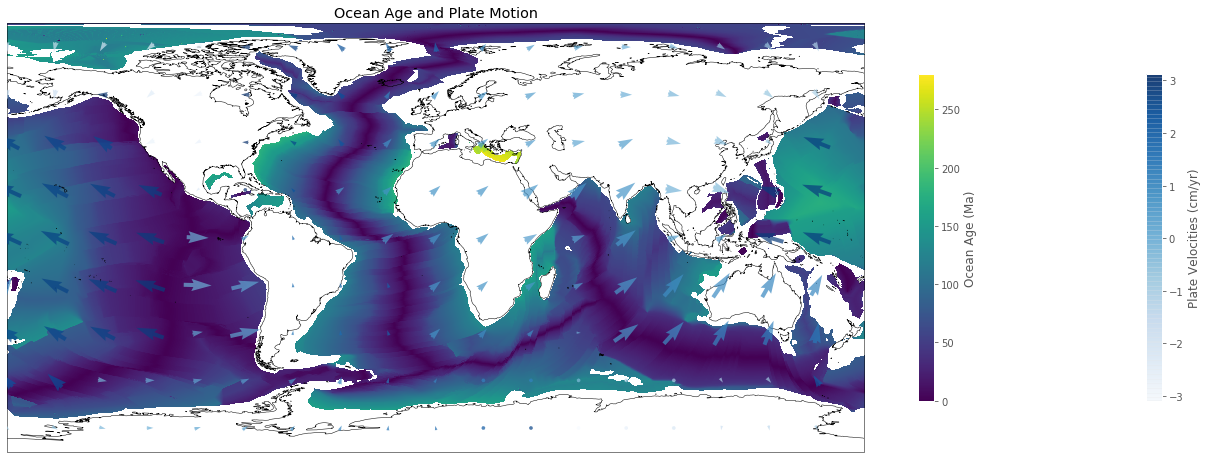

In [332]:
base_projection = ccrs.PlateCarree() 
extent = [-180, 180,-90,90]

#Plot map
fig = plt.figure(figsize=(24, 12), facecolor="none")
ax = plt.axes(projection=base_projection)
ax.coastlines(resolution='50m', zorder=1)  
mappable2 = ax.imshow(ages, extent = extent, transform = ccrs.PlateCarree(), origin="upper", )


mappable1 = ax.quiver(llX, llY, Veast, Vnorth, Vorientation, scale=2000, transform=ccrs.PlateCarree(),
        cmap=cm.Blues, alpha=0.7, zorder=13, pivot="mid")

plt.colorbar(mappable1, shrink=0.5, label = 'Plate Velocities (cm/yr)')
plt.colorbar(mappable2, shrink=0.5, label = 'Ocean Age (Ma)')
plt.title("Ocean Age and Plate Motion")
#print(llX.shape, llY.shape) 

### Map of Ocean Depth

Text(0.5, 1.0, 'Ocean Depth and Tectonic Plate Motion')

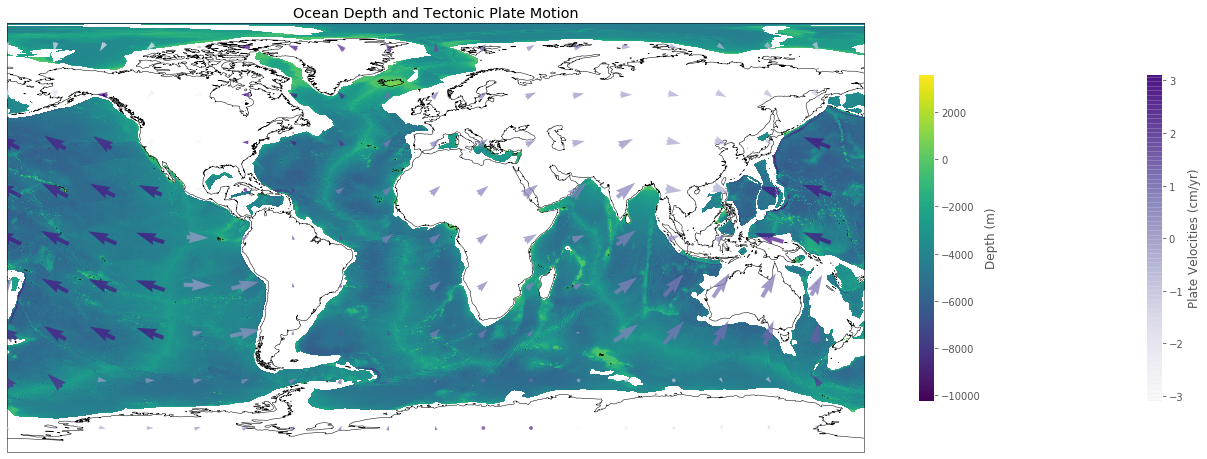

In [333]:
base_projection = ccrs.PlateCarree() 
extent=[-180, 180,-90,90]

#Plot map
fig = plt.figure(figsize=(24, 12), facecolor="none")
ax = plt.axes(projection=base_projection)
ax.coastlines(resolution='50m', zorder=1)  
mappable3 = ax.imshow(topo_1, extent = extent, transform = ccrs.PlateCarree(), origin="upper", )
mappable1 = ax.quiver(llX, llY, Veast, Vnorth, Vorientation, scale=2000, transform=ccrs.PlateCarree(),
        cmap=cm.Purples, alpha=0.7, zorder=13, pivot="mid")

plt.colorbar(mappable1, shrink=0.5, label='Plate Velocities (cm/yr)')
plt.colorbar(mappable3, shrink=0.5, label = 'Depth (m)')
plt.title("Ocean Depth and Tectonic Plate Motion")
#print(llX.shape, llY.shape)  

### Task

Make a scatter plot of the depth against age. You might need to downsample the number of points as there are a lot of them:

```python 
ages_decimated = ages[::10]
topo_decimated = etopoH[::10]
``` 

# Q: Do you see any systematic trend ?     
# A: I see no trend

In [337]:
ages_decimated = ages[::10]
topo_decimated = topo_1[::10]

Text(0.5, 0, 'Age (Ma)')

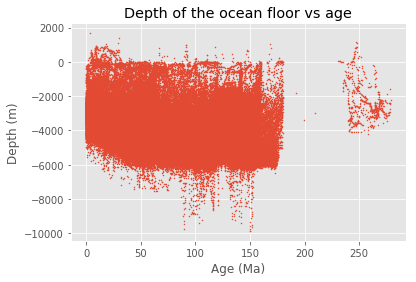

In [338]:
fig = plt.scatter(ages_decimated, topo_decimated, s=1)
plt.title("Depth of the ocean floor vs age")
plt.ylabel("Depth (m)")
plt.xlabel("Age (Ma)")

# Smoothing

Now try interpolating the bathymetry to a smoothed / downsampled version of the ages.

```python
ages_reduced = ages[::8,::8] # This is arbitrary, you should try some different ones

# OR

ages_reduced2 = imresize(ages, (226,451), interp='bilinear', mode="F")

# OR

ages_reduced2 = imresize(ages, (226,451), interp='bicubic', mode="F")

# OR

ages_reduced2 = imresize(ages, (226,451), interp='lanczos', mode="F")
```

Comment on which of these is the more effective.


In [339]:
ages_reduced  = ages[::8,::8] # This is arbitrary, you should try some different ones
ages_reduced2 = imresize(ages, (226,451), interp='bilinear', mode="F")
ages_reduced3 = imresize(ages, (226,451), interp= 'bicubic', mode = "F")
ages_reduced4 = imresize(ages, (226,451), interp='lanczos', mode="F")

topo_reduced  = topo_1[::8,::8] # This is arbitrary, you should try some different ones
topo_reduced2 = imresize(topo_1, (226,451), interp='bilinear', mode="F")
topo_reduced3 = imresize(topo_1, (226,451), interp= 'bicubic', mode = "F")
topo_reduced4 = imresize(topo_1, (226,451), interp='lanczos', mode="F")

/Users/Indi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  
/Users/Indi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Indi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  after removing the cwd from sys.path.
/Users/Indi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 

### Task

Plot the age/depth data and see if it looks smoother.

Make a scatterplot with this data too (note: you will have to downsample the bathymetry too)

Does smoothing help bring out a trend ?


Text(0.5, 1.0, 'Lanczos')

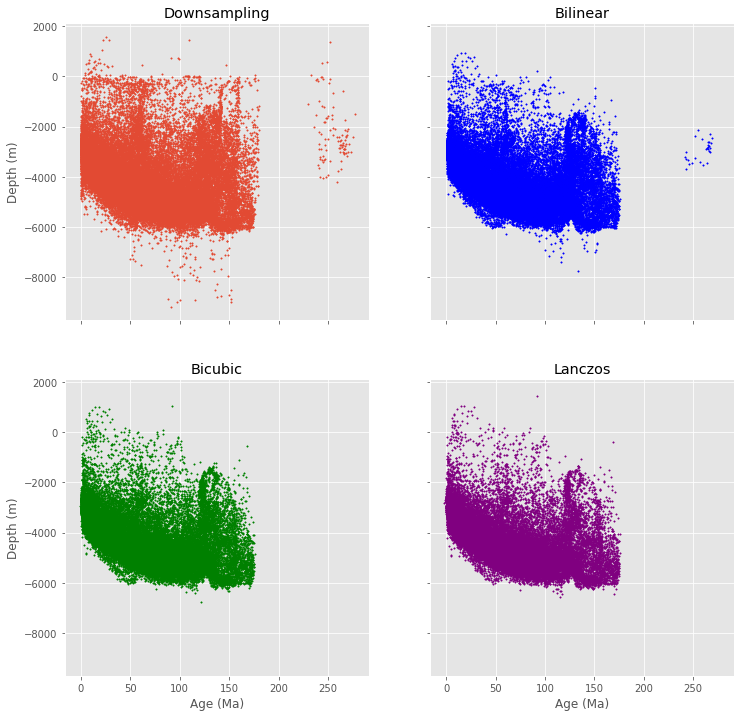

In [340]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=2, nrows=2, sharex='all', sharey='all')
ax1, ax2, ax3, ax4 = axes.ravel()
fig.set_size_inches((12,12))

ax1.scatter(ages_reduced, topo_reduced, s=2)
ax1.set_ylabel("Depth (m)")
ax1.set_title('Downsampling')

ax2.scatter(ages_reduced2, topo_reduced2, s=2, c='blue')
ax2.set_title('Bilinear')

ax3.scatter(ages_reduced3, topo_reduced3, s=2, c='green')
ax3.set_xlabel('Age (Ma)')
ax3.set_ylabel('Depth (m)')
ax3.set_title("Bicubic")

ax4.scatter(ages_reduced4, topo_reduced4, s=2, c='purple')
ax4.set_xlabel('Age (Ma)')
ax4.set_title("Lanczos")

### Task

Fit $ \textrm{depth} = A + B\sqrt{\textrm{age}} $ to this data and create a plot

You should be able to use 

```python
from scipy.optimize import curve_fit
help(curve_fit)
```



In [341]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

### Masking Nan Values

In [342]:
maskage = ages_reduced4 > 0

ages_reduced5 = ages_reduced4[maskage]
topo_reduced5 = topo_reduced4[maskage]

/Users/Indi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


### Masking depths above sea level (0 m)

In [343]:
maskdepth = topo_reduced5 < 0
ages_reduced6 = ages_reduced5[maskdepth]
topo_reduced6 = topo_reduced5[maskdepth]

print(topo_reduced5.shape)
print(topo_reduced6.shape)
print(ages_reduced5.shape)
print(ages_reduced6.shape)

(40410,)
(40372,)
(40410,)
(40372,)


# Curve fitting

In [344]:
from scipy.optimize import curve_fit
#help(curve_fit)

x=np.arange(0,200,10)

def function (x,A,B):
    return A + B*sqrt(x)

#func = curve_fit(function, ages_reduced5, topo_reduced5)
popt, pcov = curve_fit(function, ages_reduced6, topo_reduced6)
print ("function(x. a={}, b={})".format(popt[0],popt[1]))
#func

function(x. a=-3166.277966789412, b=-159.51863795854726)


Text(0.5, 1.0, 'Age vs Depth - Line of Best Fit')

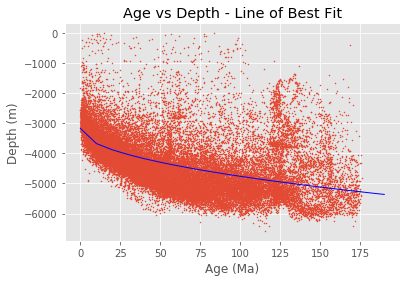

In [346]:
# plot curve of best fit. plot A and B, x data

plt.plot(x, function(x, -3166.277966789412, -159.51863795854726), linewidth=1, color='blue')
plt.scatter(ages_reduced6, topo_reduced6, s=1)
plt.xlabel('Age (Ma)')
plt.ylabel('Depth (m)')
plt.title('Age vs Depth - Line of Best Fit')

### Discussion

Obviously there are problems with the data - looking at every pixel in the image does not account for regions where there are sea mounts or other features on the ocean floor that we might consider anomalous. Actually, the other reason this doesn't work very well is that it fails to account for sediment accumulation and loading.